In [ ]:
import numpy as np
import itertools
from plotly import express as px
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, fixed
from sklearn.model_selection import train_test_split
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
input_data = pd.read_csv('/content/drive/MyDrive/Malmo_Data_3years.csv', thousands=',') # change to 5years file

USE_YEARS = [2019, 2020, 2021] # enter the years wanted in the dataset

input_data["datetime"] = pd.to_datetime(input_data['datetime'])
input_data['year'] = input_data['datetime'].dt.year
input_data['day of year'] = input_data['datetime'].dt.dayofyear
input_data['hour'] = input_data['datetime'].dt.hour

cols = input_data.columns.tolist()
cols = cols[-3:] + cols[2:-3] # add year, day and hour first - remove city and datetime column
input_data = input_data[cols]
input_data = input_data[input_data['year'].isin(USE_YEARS)]
input_data.describe()

,year,day of year,hour,temp [°C],humidity [%],precip [mm],wind speed [kph],wind dir [°],cloudcover [%],solar radiation [W/m2],electricity [kW]
count,26304.00000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26296.000000,26304.000000
mean,2020.00000,183.191188,11.500000,10.092978,78.924151,0.478279,11.123567,210.342579,59.340785,97.513382,0.133404
std,0.81614,105.467464,6.922318,6.878548,15.891411,2.152828,6.411403,96.938533,39.164139,173.876265,0.218299
min,2019.00000,1.000000,0.000000,-11.100000,18.960000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2019.00000,92.000000,5.750000,5.000000,69.410000,0.000000,6.500000,134.000000,17.000000,0.000000,0.000000
50%,2020.00000,183.000000,11.500000,9.400000,83.240000,0.000000,10.500000,235.000000,73.300000,8.000000,0.000000
75%,2021.00000,275.000000,17.250000,15.300000,91.740000,0.000000,15.100000,283.000000,96.700000,107.000000,0.186000
max,2021.00000,366.000000,23.000000,31.100000,100.000000,23.570000,49.900000,360.000000,100.000000,905.000000,0.865000


In [ ]:
# Handle the missing data
coordinates_of_NaN = np.where(input_data.isna())
row_col_of_NaN = np.array([(int(x), input_data.columns[y]) for x, y in zip(coordinates_of_NaN[0], coordinates_of_NaN[1])])

print(row_col_of_NaN)

rows_to_access = row_col_of_NaN[:,0].astype(int).tolist()
columns_to_impute = list(set(row_col_of_NaN[:,1].flatten()))

for column_to_impute in columns_to_impute:
  if column_to_impute == 'solar radiation [W/m2]':
  # this needs to be done per "column to impute"
    temp_df = pd.DataFrame()
    temp_df['ffill'] = input_data[column_to_impute].fillna(method='ffill')
    temp_df['bfill'] = input_data[column_to_impute].fillna(method='bfill')
    temp_df['meanfill'] = temp_df.mean(axis=1)
    temp_df['solar_radiation_NaN_filled'] = input_data[column_to_impute].fillna(temp_df.pop('meanfill'))
    temp_df['solar_radiation_filled_rolled'] = temp_df['solar_radiation_NaN_filled'].rolling(7, center=True, min_periods=1).mean() # sliding window (rolling mean)
    temp_df['imputed_solar_radiation'] = input_data[column_to_impute].fillna(temp_df.pop('solar_radiation_filled_rolled'))

    values_to_access = temp_df.loc[rows_to_access] # to verify the fill

    input_data[column_to_impute] = temp_df['imputed_solar_radiation']
  else:
    print(column_to_impute, "has no fill method implemented")


x = input_data[['year', 'day of year', 'hour', 'temp [°C]', 'humidity [%]', 'precip [mm]', 'wind speed [kph]', 'wind dir [°]', 'cloudcover [%]', 'solar radiation [W/m2]']]
y = input_data[['electricity [kW]']]

input_data.describe()


[['3427' 'solar radiation [W/m2]']
 ['5584' 'solar radiation [W/m2]']
 ['5585' 'solar radiation [W/m2]']
 ['5586' 'solar radiation [W/m2]']
 ['5587' 'solar radiation [W/m2]']
 ['7623' 'solar radiation [W/m2]']
 ['7624' 'solar radiation [W/m2]']
 ['10260' 'solar radiation [W/m2]']]


,year,day of year,hour,temp [°C],humidity [%],precip [mm],wind speed [kph],wind dir [°],cloudcover [%],solar radiation [W/m2],electricity [kW]
count,26304.00000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,2020.00000,183.191188,11.500000,10.092978,78.924151,0.478279,11.123567,210.342579,59.340785,97.511138,0.133404
std,0.81614,105.467464,6.922318,6.878548,15.891411,2.152828,6.411403,96.938533,39.164139,173.852440,0.218299
min,2019.00000,1.000000,0.000000,-11.100000,18.960000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2019.00000,92.000000,5.750000,5.000000,69.410000,0.000000,6.500000,134.000000,17.000000,0.000000,0.000000
50%,2020.00000,183.000000,11.500000,9.400000,83.240000,0.000000,10.500000,235.000000,73.300000,8.000000,0.000000
75%,2021.00000,275.000000,17.250000,15.300000,91.740000,0.000000,15.100000,283.000000,96.700000,107.000000,0.186000
max,2021.00000,366.000000,23.000000,31.100000,100.000000,23.570000,49.900000,360.000000,100.000000,905.000000,0.865000


In [ ]:
train_set_x_orig, test_set_x_orig, train_set_y_orig, test_set_y_orig = train_test_split(x, y, test_size=0.25, random_state=42)

#Categorizing the data into inputs (x) and outputs (y) as well as training set and testing set

train_set_x_orig


,year,day of year,hour,temp [°C],humidity [%],precip [mm],wind speed [kph],wind dir [°],cloudcover [%],solar radiation [W/m2]
4279,2019,179,8,19.5,68.67,0.000,8.1,341.0,13.1,316.0
13480,2020,197,17,18.6,64.77,0.000,4.1,237.0,60.2,460.0
9325,2020,24,13,6.6,92.99,0.010,14.7,261.0,94.1,86.0
18632,2021,46,8,-2.5,89.85,0.000,9.5,157.0,68.5,16.0
23403,2021,245,4,10.3,94.83,0.000,0.8,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21575,2021,169,0,20.6,65.69,0.000,13.1,136.0,0.0,0.0
5390,2019,225,15,14.3,89.12,1.152,12.9,295.0,89.8,165.0
860,2019,36,20,4.6,78.35,0.000,15.3,263.0,95.9,0.0
15795,2020,294,4,7.3,94.40,0.000,5.7,142.0,95.7,0.0


In [ ]:
#Normalization process
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
test_set_x_normalized = scaler.fit_transform(test_set_x_orig)
test_set_y_normalized = scaler.fit_transform(test_set_y_orig.values.reshape(-1, 1))
train_set_x_normalized = scaler.fit_transform(train_set_x_orig)
train_set_y_normalized = scaler.fit_transform(train_set_y_orig.values.reshape(-1, 1))


#Transpose the data to put all features in the rows and all samples in the columns
test_set_x_normalized = test_set_x_normalized.T
test_set_y_normalized = test_set_y_normalized.T
train_set_x_normalized = train_set_x_normalized.T
train_set_y_normalized = train_set_y_normalized.T

In [ ]:
m_test = test_set_x_orig.shape[0]
print ("Number of testing examples: m_test = " + str(m_test))
print ("test_set_x shape: " + str(test_set_x_normalized.shape))
print ("test_set_y shape: " + str(test_set_y_normalized.shape))
print ("train_set_x shape: " + str(train_set_x_normalized.shape))
print ("train_set_y shape: " + str(train_set_y_normalized.shape))

Number of testing examples: m_test = 6576
test_set_x shape: (10, 6576)
test_set_y shape: (1, 6576)
train_set_x shape: (10, 19728)
train_set_y shape: (1, 19728)


In [ ]:
def layer_sizes(X, Y):
    n_x = X.shape[0]
    n_h = 100
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

In [ ]:
def initialize_parameters(n_x, n_h, n_y):

    W1 = np.random.randn(n_h,n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y,n_h)*0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [ ]:
def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s

In [ ]:
def relu(z):
    return np.maximum(0, z)

In [ ]:
def forward_propagation(X, parameters):
    W1 = parameters.get("W1")
    b1 = parameters.get("b1")
    W2 = parameters.get("W2")
    b2 = parameters.get("b2")

    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [ ]:
def compute_cost(A2, Y):

    m = Y.shape[1]
    logprobs = np.multiply(Y,np.log(A2)) + np.multiply((1-Y),np.log(1-A2))
    cost = - (1/m) * np.sum(logprobs)

    cost = float(np.squeeze(cost))

    return cost

In [ ]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]

    W1 = parameters.get("W1")
    W2 = parameters.get("W2")

    A1 = cache.get("A1")
    A2 = cache.get("A2")

    dZ2 = A2-Y
    dW2 = (1/m)*np.dot(dZ2, np.transpose(A1))
    db2 = (1/m)*np.sum(dZ2,axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (A1 > 0)
    dW1 = (1/m)*np.dot(dZ1,np.transpose(X))
    db1 = (1/m)*np.sum(dZ1,axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate=0.1):

    W1 = copy.deepcopy(parameters.get("W1"))
    b1 = parameters.get("b1")
    W2 = copy.deepcopy(parameters.get("W2"))
    b2 = parameters.get("b2")

    dW1 = grads.get("dW1")
    db1 = grads.get("db1")
    dW2 = grads.get("dW2")
    db2 = grads.get("db2")

    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [ ]:
def nn_model(X, Y, n_h, num_iterations = 5000, learning_rate=0.1, print_cost=False):

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]


    parameters =initialize_parameters(n_x, n_h, n_y)


    for i in range(int(num_iterations)):

        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost (A2, Y)
        grads = backward_propagation (parameters, cache, X, Y)
        parameters = update_parameters (parameters, grads, learning_rate)


    return parameters

In [ ]:
def predict(parameters, X):

    A2, cache = forward_propagation(X, parameters)
    predictions = A2

    return predictions

In [ ]:
#I have already tunned the hyperparameters below, this code is to plot the graphs using the best combination of hyperparameters:
X = train_set_x_normalized
Y = train_set_y_normalized
learning_rate = .1
num_iterations = 5000
hidden_layer_sizes = [100]

best_test_accuracy = 0
best_train_accuracy = 0
best_hidden_layer_size = None

for i, n_h in enumerate(hidden_layer_sizes):
    X = train_set_x_normalized
    Y = train_set_y_normalized
    parameters = nn_model(X, Y, n_h, print_cost=False)
    Y_prediction_train = predict(parameters, X)
    Train_accuracy=(100 - np.mean(np.abs(Y_prediction_train - train_set_y_normalized)) * 100)

    X = test_set_x_normalized
    Y_prediction_test = predict(parameters, X)
    Test_accuracy=(100 - np.mean(np.abs(Y_prediction_test - test_set_y_normalized)) * 100)

     # Print and compare accuracies
    print("Hidden Layer Size: {} | Train Accuracy: {}% | Test Accuracy: {}%".format(n_h, Train_accuracy, Test_accuracy))

    # Check if the current model has the best test accuracy
    if Test_accuracy > best_test_accuracy and Train_accuracy > best_train_accuracy:
        best_test_accuracy = Test_accuracy
        best_hidden_layer_size = n_h

# Print the best result
print("\nBest Hidden Layer Size: {} | Best Test Accuracy: {}%".format(best_hidden_layer_size, best_test_accuracy))

Hidden Layer Size: 100 | Train Accuracy: 92.13548442610372% | Test Accuracy: 92.31196860779528%

Best Hidden Layer Size: 100 | Best Test Accuracy: 92.31196860779528%


In [ ]:
#Reverse normalization
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Reverse the normalization to get the original data
Y_prediction_test_real_scale = scaler.inverse_transform(predict(parameters, test_set_x_normalized))
plot_df = pd.DataFrame(test_set_y_orig)
plot_df["prediction"] = Y_prediction_test_real_scale.T

plot_df = plot_df.sort_index()

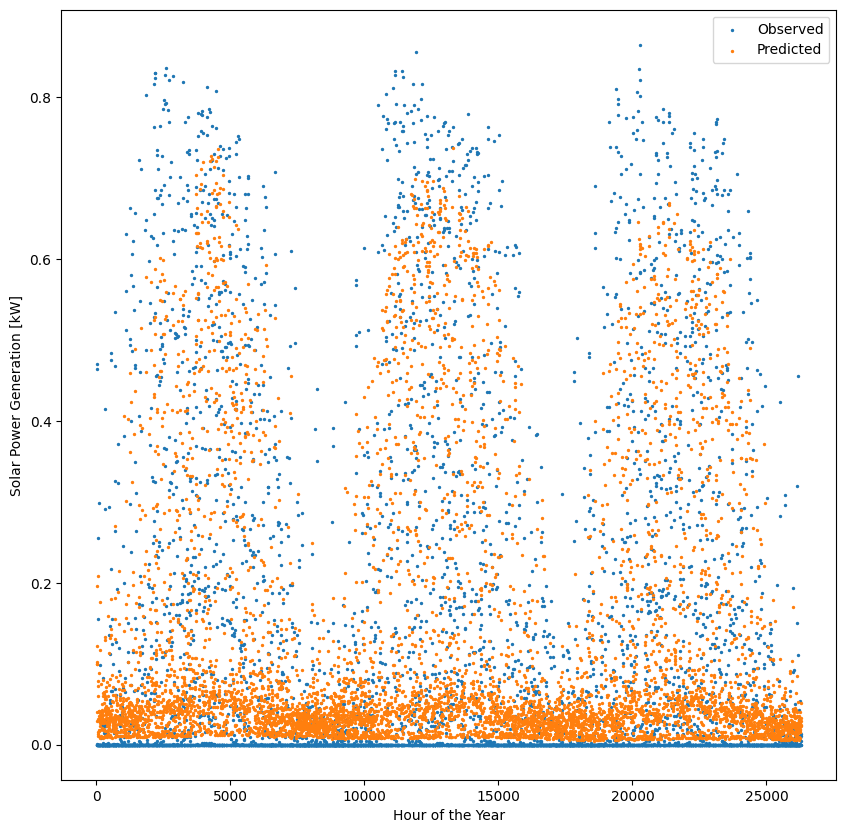

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot actual values
ax.scatter(plot_df.index, plot_df["electricity [kW]"], label='Observed', s=2)

# Plot predicted values
ax.scatter(plot_df.index, plot_df["prediction"], label='Predicted', s=2)

plt.xlabel('Hour of the Year')
plt.ylabel('Solar Power Generation [kW]')
plt.legend()

plt.savefig("Logistic Regression scatter.jpg")
plt.show()

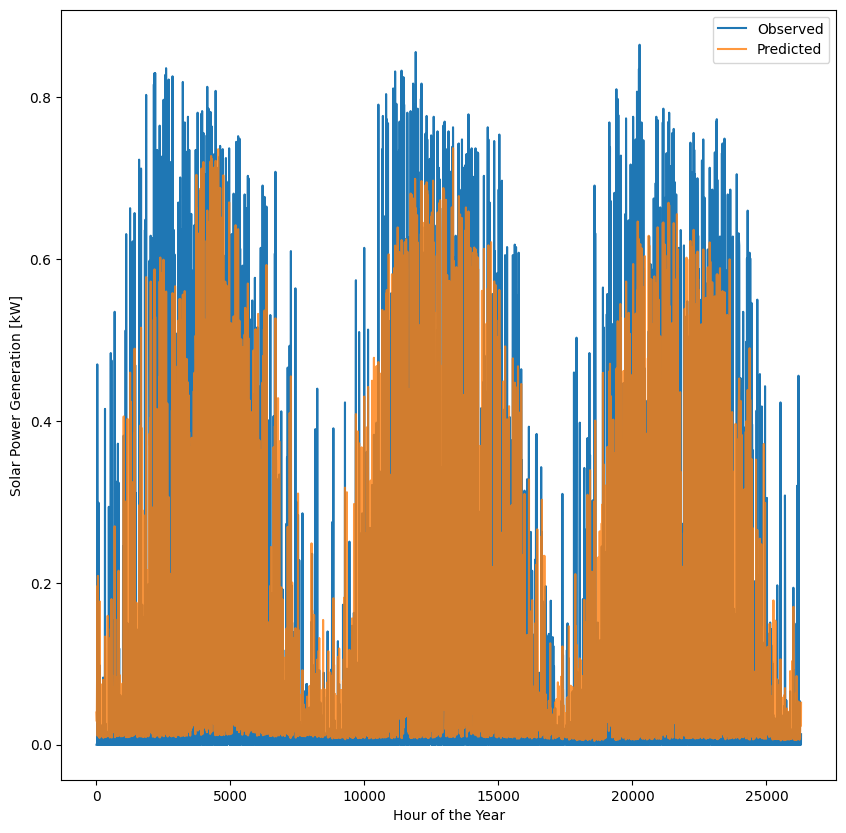

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot actual values
ax.plot(plot_df["electricity [kW]"], label='Observed')

# Plot predicted values
ax.plot(plot_df["prediction"], label='Predicted', alpha=0.8)

plt.xlabel('Hour of the Year')
plt.ylabel('Solar Power Generation [kW]')
plt.legend()

plt.savefig("Logistic Regression line.jpg")
plt.show()

**Tuning the Hyperparameters**

The code below is to find the best combination of the hyperparameters (learning rate, hidden units and number of iterations). Important is to say that running the code with a wide range for the hyperparameters will be highly time consuming. As an example, running the code as it is writen below, will take more than 5 hours, so when run the code, try to peak small ranges such as:

learning rates: [0,001, 0,01]
n_h : [20, 60, 100]
num_iterations : [1000, 5000, 10000]

This will consume at least 4 hours.

In [ ]:
import time

# Define a range of hyperparameter values
X = train_set_x_normalized
Y = train_set_y_normalized
learning_rates = [0.001, 0.01, 0.1]
n_h_values = [20, 60, 100]
num_iterations_values = [1000, 5000,10000]

best_test_accuracy = 0
best_train_accuracy = 0
best_hyperparameters = None
results = []  # Store results for analysis


# Iterate over hyperparameter combinations
for lr in learning_rates:
    for units in n_h_values:
        for ni in num_iterations_values:
            # Start the timer for the current combination
            combination_start_time = time.time()

            # Train your shallow neural network with the current hyperparameters
            parameters = nn_model(X, Y, n_h=units, num_iterations=ni, learning_rate=lr)

            Y_prediction_train = predict(parameters, X)
            Train_accuracy = (100 - np.mean(np.abs(Y_prediction_train - train_set_y_normalized)) * 100)

            X_test = test_set_x_normalized
            Y_prediction_test = predict(parameters, X_test)
            Test_accuracy = (100 - np.mean(np.abs(Y_prediction_test - test_set_y_normalized)) * 100)

            # Store results
            results.append({
                'learning_rate': lr,
                'hidden_units': units,
                'num_iterations': ni,
                'train_accuracy': Train_accuracy,
                'test_accuracy': Test_accuracy,
                'time_taken': time.time() - combination_start_time})

            # Check if this combination is the best so far on the test set
            if Test_accuracy > best_test_accuracy:
                best_test_accuracy = Test_accuracy
                best_train_accuracy = Train_accuracy
                best_hyperparameters = {'learning_rate': lr, 'hidden_units': units, 'num_iterations': ni}

            # Check if the processing time exceeds the maximum
            #elapsed_time = time.time() - start_time
            #if elapsed_time > max_processing_time:
                #print("Time limit reached. Exiting...")
                #break

# Print all hyperparameter combinations and their accuracies
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Hidden Units: {result['hidden_units']}, "
          f"Num Iterations: {result['num_iterations']}, Train Accuracy: {result['train_accuracy']}, "
          f"Test Accuracy: {result['test_accuracy']}, Time Taken: {result['time_taken']} seconds")

# Print the best hyperparameters and corresponding accuracies
print("Best Hyperparameters:", best_hyperparameters)
print("Best Train Accuracy:", best_train_accuracy)
print("Best Test Accuracy:", best_test_accuracy)

<ipython-input-45-9e600bed2222>:23: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(Y,np.log(A2)) + np.multiply((1-Y),np.log(1-A2))
<ipython-input-45-9e600bed2222>:23: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(Y,np.log(A2)) + np.multiply((1-Y),np.log(1-A2))
<ipython-input-42-2cac3e6932ac>:2: RuntimeWarning: overflow encountered in exp
  s=1/(1+np.exp(-z))
<ipython-input-46-8ade589a0723>:48: RuntimeWarning: overflow encountered in power
  dZ1 = np.transpose(W2)*dZ2*(1-np.power(A1, 2))
<ipython-input-46-8ade589a0723>:48: RuntimeWarning: invalid value encountered in multiply
  dZ1 = np.transpose(W2)*dZ2*(1-np.power(A1, 2))
<ipython-input-46-8ade589a0723>:48: RuntimeWarning: overflow encountered in multiply
  dZ1 = np.transpose(W2)*dZ2*(1-np.power(A1, 2))


Learning Rate: 0.001, Hidden Units: 20, Num Iterations: 1000, Train Accuracy: 65.08537072142036, Test Accuracy: 64.76801310241345, Time Taken: 23.98468279838562 seconds
Learning Rate: 0.001, Hidden Units: 20, Num Iterations: 5000, Train Accuracy: 74.61358616140014, Test Accuracy: 74.64154103175396, Time Taken: 121.97297525405884 seconds
Learning Rate: 0.001, Hidden Units: 20, Num Iterations: 10000, Train Accuracy: 78.01186451720913, Test Accuracy: 78.2137454671571, Time Taken: 247.7655849456787 seconds
Learning Rate: 0.001, Hidden Units: 60, Num Iterations: 1000, Train Accuracy: 65.15678320386746, Test Accuracy: 64.84107571508129, Time Taken: 75.51990485191345 seconds
Learning Rate: 0.001, Hidden Units: 60, Num Iterations: 5000, Train Accuracy: 75.1847084237836, Test Accuracy: 75.23445802539122, Time Taken: 378.8678033351898 seconds
Learning Rate: 0.001, Hidden Units: 60, Num Iterations: 10000, Train Accuracy: 79.06321852884571, Test Accuracy: 79.30313656096372, Time Taken: 751.3788492